# Graph

In this tutorial we introduce the notion of `MultiLayerGraph`, how to construct and manipulate it.

`MultiLayerGraph` is made of two component, the `graph` and the `roads`. The first one is an multi layer oriented graph represensting the all the mobility services and their connections inside one connected graph, the second one is a physical descriptions of the roads inside your network.

## Create a simple RoadDescriptor

### Instantiation

In [4]:
from mnms.graph.road import RoadDescriptor

roads = RoadDescriptor()
roads

### Registering nodes

In [5]:
roads.register_node('IN', [-50, 0])
roads.register_node('0', [0, 0])
roads.register_node('1', [100, 0])
roads.register_node('2', [100, 100])
roads.register_node('3', [0, 100])
roads.register_node('OUT', [150, 100]) 

roads.nodes

{'IN': RoadNode(id='IN', position=array([-50,   0])),
 '0': RoadNode(id='0', position=array([0, 0])),
 '1': RoadNode(id='1', position=array([100,   0])),
 '2': RoadNode(id='2', position=array([100, 100])),
 '3': RoadNode(id='3', position=array([  0, 100])),
 'OUT': RoadNode(id='OUT', position=array([150, 100]))}

### Registering sections

In [6]:
roads.register_section('IN_0', 'IN', '0')
roads.register_section('0_1', '0', '1')
roads.register_section('1_2', '1', '2')
roads.register_section('0_3', '0', '3')
roads.register_section('3_2', '3', '2')
roads.register_section('2_OUT', '2', 'OUT')

roads.sections

{'IN_0': RoadSection(id='IN_0', upstream='IN', downstream='0', length=50.0, zone=None),
 '0_1': RoadSection(id='0_1', upstream='0', downstream='1', length=100.0, zone=None),
 '1_2': RoadSection(id='1_2', upstream='1', downstream='2', length=100.0, zone=None),
 '0_3': RoadSection(id='0_3', upstream='0', downstream='3', length=100.0, zone=None),
 '3_2': RoadSection(id='3_2', upstream='3', downstream='2', length=100.0, zone=None),
 '2_OUT': RoadSection(id='2_OUT', upstream='2', downstream='OUT', length=50.0, zone=None)}

### Registering stops

In [7]:
roads.register_stop('S0', 'IN_0', 0.4)
roads.register_stop('S1', '3_2', 0.75)


roads.stops

{'S0': RoadStop(id='S0', section='IN_0', relative_position=0.4, absolute_position=array([-30.,   0.])),
 'S1': RoadStop(id='S1', section='3_2', relative_position=0.75, absolute_position=array([ 75., 100.]))}

### Rendering

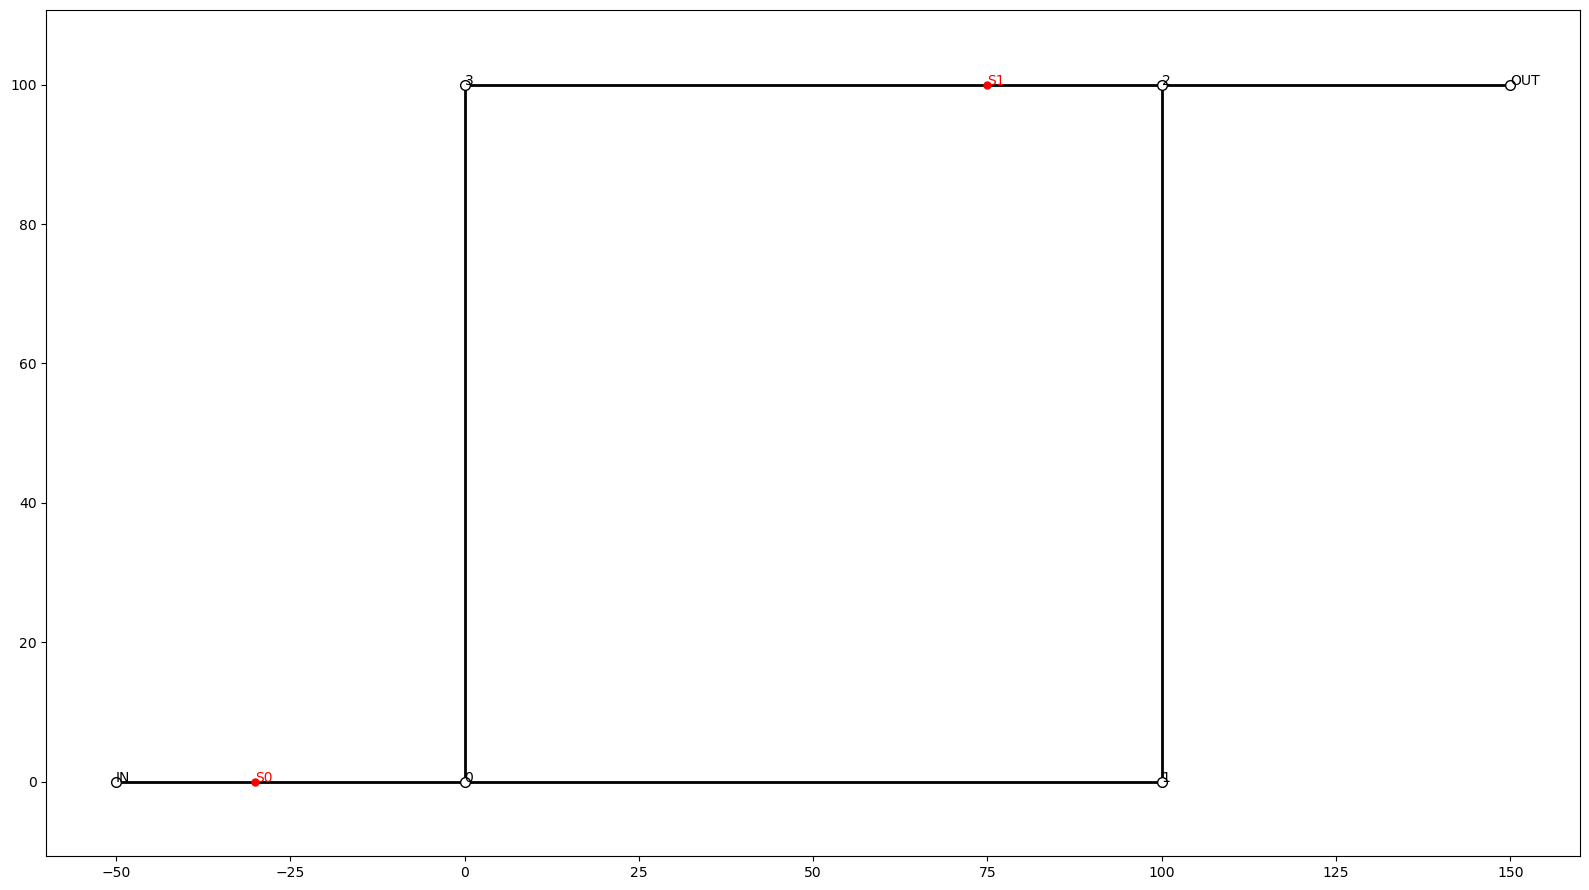

In [8]:
from mnms.tools.render import draw_roads
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))
draw_roads(ax, roads, nodesize=7, linkwidth=2, label_size=10)

## Add Layers and mobility services

A Layer of the mobility graph is associated to a type of Vehicle, mobility services are associated to a layer. The Layer is a graph representation and the mobility service contains the logic for managing a fleet of Vehicle.

### Car layer with a personal car mobility service

In [9]:
from mnms.graph.layers import CarLayer
from mnms.mobility_service.personal_vehicle import PersonalMobilityService

SPEED_CAR = 10

car_layer = CarLayer(roads,
               default_speed=SPEED_CAR,
               services=[PersonalMobilityService()])

car_layer.create_node('CIN', 'IN')
car_layer.create_node('C0', '0')
car_layer.create_node('C1', '1')
car_layer.create_node('C2', '2')
car_layer.create_node('COUT', 'OUT')

car_layer.create_link('CIN_C0', 'CIN', 'C0', {}, ['IN_0'])
car_layer.create_link('C0_C1', 'C0', 'C1', {}, ['0_1'])
car_layer.create_link('C1_C2', 'C1', 'C2', {}, ['1_2'])
car_layer.create_link('C2_COUT', 'C2', 'COUT', {}, ['2_OUT'])

car_layer.mobility_services

{'PersonalVehicle': <mnms.mobility_service.personal_vehicle.PersonalMobilityService at 0x30e53ef20>}

### Bus layer with a public transportmobility service

In [10]:
from mnms.graph.layers import PublicTransportLayer
from mnms.mobility_service.public_transport import PublicTransportMobilityService
from mnms.time import TimeTable, Dt
from mnms.vehicles.veh_type import Bus

SPEED_BUS = 5

bus_service = PublicTransportMobilityService('BUS')
bus_layer = PublicTransportLayer(roads, 'BUS', Bus, SPEED_BUS, services=[bus_service])

bus_line = bus_layer.create_line('L1', ['S0', 'S1'], [['IN_0','0_3','3_2']], TimeTable.create_table_freq('07:00:00', '18:00:00', Dt(minutes=10)))


### Origin destilation layer 

In [ ]:
from mnms.generation.layers import generate_matching_origin_destination_layer
odlayer = generate_matching_origin_destination_layer(roads)

### Add the mobility services and the od layer to the MultiModalGraph

Then we add the two mobility services to the `MultiModalGraph`. And check that there is no duplicate in the nodes and links.

In [13]:
from mnms.graph.layers import MultiLayerGraph

mmgraph = MultiLayerGraph([car_layer, bus_layer],
                          odlayer,
                          250)

mmgraph.layers

{'CAR': <mnms.graph.layers.CarLayer at 0x110bd29b0>,
 'BUS': <mnms.graph.layers.PublicTransportLayer at 0x30e5fba00>}

## Save graph

You can save the `MultiModalGraph` in a json format using the `io` module.

In [14]:
from mnms.io.graph import save_graph

save_graph(mmgraph, 'mmgraph.json')

And reload it using the `load_graph` function:

In [15]:
from mnms.io.graph import load_graph

new_mmgraph = load_graph('mmgraph.json')
